In [42]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstwobign, chi2, gamma
eps = 0.05
random.seed(23)

In [43]:
class LCG: 
    def __init__(self, a, c, m, start, n):
        self.a = a
        self.c = c
        self.m = m
        self.start = start
        self.generated = []
        self.count_n_items(n)
        self.U = [i / self.m for i in self.generated]

    
    def __str__(self) -> str:
        return "Linear Congruent Generator:\n x_n+1 = ({} * x_n + {}) mod {};  x0 = {}.".format(self.a, self.c, self.m, self.start)

    def count_next(self):
        if len(self.generated) == 0:
            return (self.a * self.start + self.c) % self.m
        elif len(self.generated) > 0:
            return (self.a * self.generated[len(self.generated) - 1] + self.c) % self.m 

    def count_n_items(self, n):
        for i in range(n+300):
            self.generated.append(self.count_next())
    
    def get_mean(self, n):
        return np.mean(self.U[:n])
    
    def get_var(self, n):
        return np.var(self.U[:n])

In [44]:
class MMG:
    def __init__(self, generator1, generator2, k, n):
        self.X = generator1
        self.Y = generator2
        self.k = k
        self.n = n
        self.V = [self.X.generated[i] for i in range(k)]
        self.U = [0 for _ in range(n)]
        self.generate()
    
    def generate(self):
        for i in range(self.n):
            s = math.floor(self.Y.generated[i] * self.k / self.Y.m)
            self.U[i] = self.V[s] / self.X.m 
            self.V[s] = self.X.generated[i+self.k]
    
    def get_mean(self, n):
        return sum(self.U[:n]) / n
    
    def get_var(self, n):
        m = 1 / n * sum(self.U[:n])
        return sum([(self.U[i] - m)**2 for i in range(n)]) / (n - 1)
            

In [45]:
n2 = 10**7
n =  10**5
generator_12 = LCG(69069, 12345, 2**32, 7, n2)
generator_13 = LCG(69070,1,2**32-5, 2**8, n2)
# генератор Маклорена-Марсальи
mmg = MMG(generator_12, generator_13, 100, n2)

Вывод информации теста

In [46]:
def print_result(test_name, alpha, value, critical_value):
    print( "{}\n\tУровень доверия: {}".format(test_name, 1-alpha))
    if value < critical_value:
        print("\tH0 принята: {} < {}.".format(value, critical_value))
    else:
        print("\tH0 не принята: {} >= {}.".format(value, critical_value))

Критерий Колмогорова

In [47]:
def ks_test(data, cdf, alpha=0.05, **kwargs):
    n = len(data)
    _cdf = np.arange(n) / n
    sorted_data = sorted(data)
    expected_cdf = np.array([cdf(x, **kwargs) for x in sorted_data])
    Dn = np.max(np.abs(expected_cdf - _cdf))
    ks_value = np.sqrt(n) * Dn
    critical_value = kstwobign.ppf(1-alpha)
    print_result("", alpha, ks_value, critical_value) 

Тест Хи-квадрат

In [48]:
def chisquare(freq_obs, freq_exp):
    chisquare = 0.0
    for i in range(len(freq_obs)):
        chisquare += ((freq_obs[i] - freq_exp[i])**2 / freq_exp[i])
    return chisquare

def expected_frequencies(first, last, cdf, **kwargs):
    freq_exp = []
    sum_prob = 0
    step = (last - first) / 1000
    freq = [first + i * step for i in range(1000)]
    for i in range(1, len(freq)):
        prob = cdf(freq[i], **kwargs) - cdf(freq[i - 1], **kwargs)
        sum_prob += prob
        freq_exp.append(prob * n)
    freq_exp.append(n * (1 - sum_prob))
    return freq_exp

def observed_frequencies(sample, first, last):
    f_obs = []
    for i in range(1000):
        f_obs.append(0)
    intervals = list(np.arange(first, last, (last - first) / 1000))
    intervals.append(last)
    sample_sorted = sorted(sample)
    i = 0
    j = 1
    while j <= 1000 and i < len(sample_sorted):
        if intervals[j-1] <= sample_sorted[i] < intervals[j]:
            f_obs[j - 1] += 1
            i += 1
        else:
            j += 1
    f_obs[len(f_obs) - 1] += n - i
    return f_obs

def perform_chi2(distribution_name, mmg, generator, cdf, **kwargs):
    first = min(generator)
    last = max(generator)
    freq_exp = expected_frequencies(first, last, cdf, **kwargs)
    freq_obs = observed_frequencies(generator, first, last)
    chi_2 = chisquare(freq_obs, freq_exp)
    first = min(mmg)
    last = max(mmg)
    freq_exp_my = expected_frequencies(first, last, cdf, **kwargs)
    freq_obs_my = observed_frequencies(mmg, first, last)
    chi_2_my = chisquare(freq_obs_my, freq_exp_my)
    delta = chi2(999).ppf(1 - eps)
    print(distribution_name)
    print_result("Хи-квадрат для встроенного генератора", eps, chi_2, delta)
    print_result("Хи-квадрат для реализованного генератора", eps, chi_2_my, delta)

Встроенный рандомный генератор

In [49]:
from random import SystemRandom
cryptogen = SystemRandom()
generator = [cryptogen.random() for _ in range(n2)]

Статистики

In [50]:
def mmean(dataset):
    return sum(dataset) / len(dataset)

def vvar(dataset):
    m = mmean(dataset)
    return sum([(dataset[i] - m)**2 for i in range(n)]) / (n - 1) 

Равномерное распределение

100000


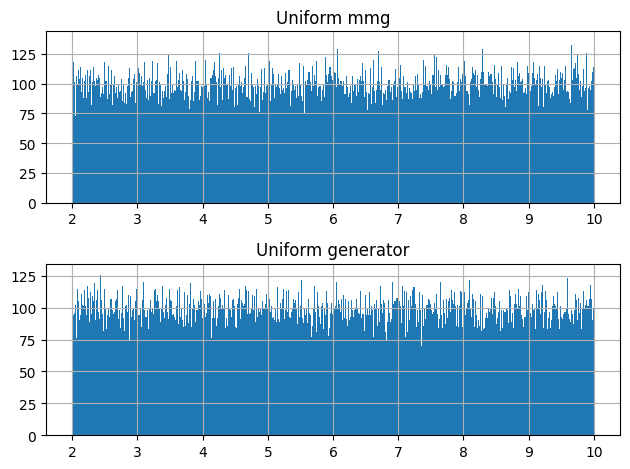

In [83]:
def uniform_(data, size, a, b):
    res = []
    for i in range(size):
        res.append((b - a) * data[i] + a)
    return res

a_uniform = 2
b_uniform = 10

uniform_mmg = uniform_(mmg.U, n, a_uniform, b_uniform)
uniform_inb = uniform_(generator, n, a_uniform, b_uniform)


fig, axs = plt.subplots(2,1)
axs[0].hist(uniform_mmg, bins = 1000)
print(len(uniform_mmg))
axs[0].set_title("Uniform mmg")
axs[0].grid(True)
axs[1].hist(uniform_inb, bins = 1000)
axs[1].set_title("Uniform generator")
axs[1].grid(True)
fig.tight_layout()
plt.show()

Статистика для равномерного распределения

In [84]:
def uniform_cdf(x, a, b):
    if x < a:
        return 0
    elif x > b:
        return 1
    else:
        return (x - a) / (b - a)

print('Статистика для нормального распределения (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:", (a_uniform + b_uniform) / 2)
print("Несмещенная оценка матожидания:", mmean(uniform_mmg))
print("Теоретическая дисперсия:", (b_uniform - a_uniform) ** 2 / 12)
print("Несмещенная оценка дисперсии:", vvar(uniform_mmg))

print('\nСтатистика для нормального распределения (встроенный генератор)')
print("Теоретическое мат. ожидание:", (a_uniform + b_uniform) / 2)
print("Несмещенная оценка матожидания:", mmean(uniform_inb))
print("Теоретическая дисперсия:", (b_uniform - a_uniform) ** 2 / 12)
print("Несмещенная оценка дисперсии:", vvar(uniform_inb))

Статистика для нормального распределения (Маклорен-Марсалья)
Теоретическое мат. ожидание: 6.0
Несмещенная оценка матожидания: 5.999250002073627
Теоретическая дисперсия: 5.333333333333333
Несмещенная оценка дисперсии: 5.3299277862220125

Статистика для нормального распределения (встроенный генератор)
Теоретическое мат. ожидание: 6.0
Несмещенная оценка матожидания: 5.992259051891237
Теоретическая дисперсия: 5.333333333333333
Несмещенная оценка дисперсии: 5.350538826732926


Критерий Колмогорова для нормального распределения

In [85]:
print('Критерий Колмогорова для MMG')
ks_test(uniform_mmg, uniform_cdf, a=a_uniform, b=b_uniform)
print('Критерий Колмогорова для встроенного генератора')
ks_test(uniform_inb, uniform_cdf, a=a_uniform, b=b_uniform)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.43484056980539315 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 0.8805607114259412 < 1.3580986393225505.


Тест Хи-квадрат для равномерного распрделения

In [86]:
perform_chi2("Нормальное распределение", uniform_mmg, uniform_inb, uniform_cdf, a = a_uniform, b = b_uniform)

Нормальное распределение
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 948.4008867648239 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 1007.3454429277151 < 1073.6426506574246.


Одномерное нормальное распределение

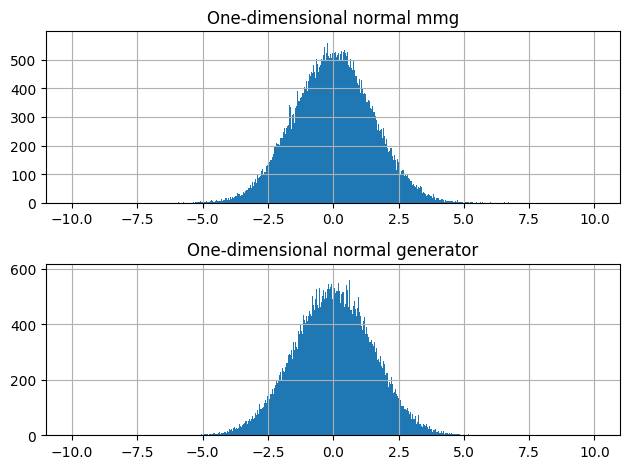

In [87]:
from scipy import special
def onedim_normal(a, n, m, s, N = 24):
    data = []
    for i in range(0, N * n, N):
        data.append(m + (12 / N) ** (0.5) * (sum(a[i:(i + N)]) - N / 2) * s)
    return data

m_onedim = 0
s_onedim = 1.5
onedim_mmg = onedim_normal(mmg.U, n, m_onedim, s_onedim)
onedim_generator = onedim_normal(generator, n, m_onedim, s_onedim)
minn = min(onedim_mmg + onedim_generator)
maxx = max(onedim_mmg + onedim_generator)
bins = list(np.arange(-10, 10, 0.02))
fig, axs = plt.subplots(2,1)
axs[0].hist(onedim_mmg, bins = bins)
axs[0].set_title("One-dimensional normal mmg")
axs[0].grid(True)
axs[1].hist(onedim_generator, bins = bins)
axs[1].set_title("One-dimensional normal generator")
axs[1].grid(True)
fig.tight_layout()
plt.show()

In [88]:
def normal_cdf(x, m, s):
    return 0.5 * (1 + math.erf((x - m) / (s * 2 ** 0.5)))

print('Статистика для одномерного нормального распределения (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:", m_onedim)
print("Jценка матожидания:", mmean(onedim_mmg))
print("Теоретическая дисперсия:", s_onedim**2)
print("Несмещенная оценка дисперсии:", vvar(onedim_mmg))

print('\nСтатистика для одномерного нормального распределения (встроенный генератор)')
print("Теоретическое мат. ожидание:", m_onedim)
print("Несмещенная оценка матожидания:", mmean(onedim_generator))
print("Теоретическая дисперсия:", s_onedim**2)
print("Несмещенная оценка дисперсии:", vvar(onedim_generator))

Статистика для одномерного нормального распределения (Маклорен-Марсалья)
Теоретическое мат. ожидание: 0
Jценка матожидания: -1.3696592521227814e-05
Теоретическая дисперсия: 2.25
Несмещенная оценка дисперсии: 2.2532322167460466

Статистика для одномерного нормального распределения (встроенный генератор)
Теоретическое мат. ожидание: 0
Несмещенная оценка матожидания: 0.0012213590761642641
Теоретическая дисперсия: 2.25
Несмещенная оценка дисперсии: 2.2652435732107294


Критерий Колмогорова для одномерного нормального распределения

In [89]:
print('Критерий Колмогорова для MMG')
ks_test(onedim_mmg, normal_cdf, m=m_onedim, s=s_onedim)
print('Критерий Колмогорова для встроенного генератора')
ks_test(onedim_generator, normal_cdf, m=m_onedim, s=s_onedim)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.8808077911796919 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 1.2377932593736085 < 1.3580986393225505.


Хи-квадрат для одномерного нормального распределения

In [90]:
perform_chi2("Одномерное нормальное распределение", onedim_mmg, onedim_generator, normal_cdf, m = m_onedim, s = s_onedim)

Одномерное нормальное распределение
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 956.0523986615343 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 966.1438647746676 < 1073.6426506574246.


Логнормальное распределение

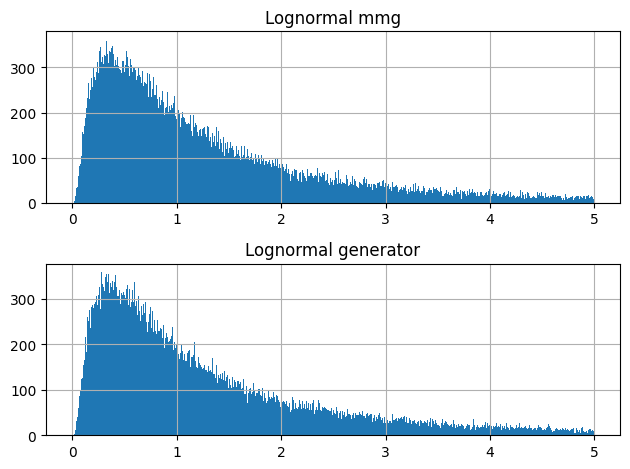

In [91]:
def lognormal(a, n, m, s):
    b = []
    for i in range(0, n * 12, 12):
        b.append(m + (sum(a[i:(i+12)]) - 6) * s)
    data = [np.exp(x) for x in b]
    return data

m_log = 0
s_log = 1
lognorm_mmg = lognormal(mmg.U, n, m_log, s_log)
lognorm_generator = lognormal(generator, n, m_log, s_log) 
minn = min(onedim_mmg + onedim_generator)
maxx = max(onedim_mmg + onedim_generator)
bins = list(np.arange(0, 5, 0.005))   
fig, axs = plt.subplots(2,1)
axs[0].hist(lognorm_mmg, bins = bins)
axs[0].set_title("Lognormal mmg")
axs[0].grid(True)
axs[1].hist(lognorm_generator, bins = bins)
axs[1].set_title("Lognormal generator")
axs[1].grid(True)
fig.tight_layout()
plt.show()    

In [92]:
def lognormal_cdf(x, m, s):
    return 0.5 * (1 + math.erf((np.log(x) - m) / (s * 2 ** 0.5)))

print('Статистика для логнормального распределения (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:", np.exp(m_log + s_log**2 / 2))
print("Несмещенная оценка матожидания:", mmean(lognorm_mmg))
print("Теоретическая дисперсия:",  (np.exp(s_log**2) - 1) * np.exp(2 * m_log + s_log**2))
print("Несмещенная оценка дисперсии:", vvar(lognorm_mmg))

print('\nСтатистика для логнормального распределения (встроенный генератор))')
print("Теоретическое мат. ожидание:", np.exp(m_log + s_log**2 / 2))
print("Несмещенная оценка матожидания:", mmean(lognorm_generator))
print("Теоретическая дисперсия:",  (np.exp(s_log**2) - 1) * np.exp(2 * m_log + s_log**2))
print("Несмещенная оценка дисперсии:", vvar(lognorm_generator))

Статистика для логнормального распределения (Маклорен-Марсалья)
Теоретическое мат. ожидание: 1.6487212707001282
Несмещенная оценка матожидания: 1.6395003103253898
Теоретическая дисперсия: 4.670774270471604
Несмещенная оценка дисперсии: 4.198024622951703

Статистика для логнормального распределения (встроенный генератор))
Теоретическое мат. ожидание: 1.6487212707001282
Несмещенная оценка матожидания: 1.6346488644220982
Теоретическая дисперсия: 4.670774270471604
Несмещенная оценка дисперсии: 4.193615776115802


Критерий Колмогорова для логнормального распределения

In [93]:
print('Критерий Колмогорова для MMG')
ks_test(lognorm_mmg, lognormal_cdf, m=m_log, s=s_log)
print('Критерий Колмогорова для встроенного генератора')
ks_test(lognorm_generator, lognormal_cdf, m=m_log, s=s_log)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.8222300886912214 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 1.2464972512496864 < 1.3580986393225505.


Хи-квадрат для логнормального

In [94]:
perform_chi2("Логнормальное распределение", lognorm_mmg, lognorm_generator, lognormal_cdf, m = m_log, s = s_log)

Логнормальное распределение
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 762.7099287719815 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 678.8021764005148 < 1073.6426506574246.


Экспоненциальное распределение

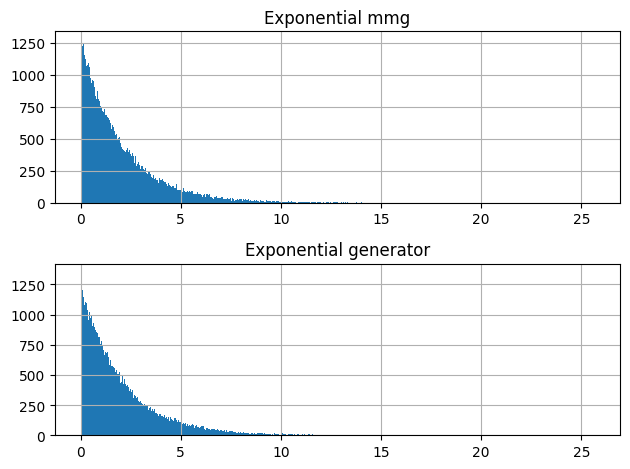

In [95]:
def exponential(a, n, m):
    data = [ ((-1) / m) * np.log(a[i]) if a[i] != 0 else 0 for i in range(n)]
    return data

m_exp = 0.5

exp_mmg = exponential(mmg.U, n, m_exp)
exp_generator = exponential(generator, n, m_exp)
minn = min(exp_mmg + exp_generator)
maxx = max(exp_mmg + exp_generator)
bins = list(np.arange(minn, maxx, (maxx - minn) / 1000))  
fig, axs = plt.subplots(2,1)
axs[0].hist(exp_mmg, bins = bins)
axs[0].set_title("Exponential mmg")
axs[0].grid(True)
axs[1].hist(exp_generator, bins = bins)
axs[1].set_title("Exponential generator")
axs[1].grid(True)
fig.tight_layout()
plt.show() 

Статистика для экспоненциального распределения

In [96]:
def exponential_cdf(x, m):
    return 1 - np.exp((-1)*m * x)
print("Статистика для экспоненциального распределения (Маклорен-Марсалья)")
print("Теоретическое мат. ожидание:", 1 / m_exp)
print("Несмещенная оценка матожидания:", mmean(exp_mmg))
print("Теоретическая дисперсия:",  1 / m_exp ** 2)
print("Несмещенная оценка дисперсии:", vvar(exp_mmg))

print("\nСтатистика для экспоненциального распределения (встроенный генератор)")
print("Теоретическое мат. ожидание:",1 / m_exp)
print("Несмещенная оценка матожидания:", mmean(exp_generator))
print("Теоретическая дисперсия:",  1 / m_exp ** 2)
print("Несмещенная оценка дисперсии:", vvar(exp_generator))

Статистика для экспоненциального распределения (Маклорен-Марсалья)
Теоретическое мат. ожидание: 2.0
Несмещенная оценка матожидания: 2.0018658185119076
Теоретическая дисперсия: 4.0
Несмещенная оценка дисперсии: 4.015240741804772

Статистика для экспоненциального распределения (встроенный генератор)
Теоретическое мат. ожидание: 2.0
Несмещенная оценка матожидания: 2.0090276325809455
Теоретическая дисперсия: 4.0
Несмещенная оценка дисперсии: 4.030113455328855


Критерий Колмогорова для экспоненционального распределения

In [97]:
print('Критерий Колмогорова для MMG')
ks_test(exp_mmg, exponential_cdf, m=m_exp)
print('Критерий Колмогорова для встроенного генератора')
ks_test(exp_generator, exponential_cdf, m=m_exp)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.4316782921452041 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 0.8837229890860953 < 1.3580986393225505.


Хи-квадрат для экспоненциального распределения

In [98]:
perform_chi2("Экспоненциальное распределение", exp_mmg, exp_generator, exponential_cdf, m = m_exp)

Экспоненциальное распределение
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 727.622310131008 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 1019.4764934679383 < 1073.6426506574246.


Распределение Лапласа

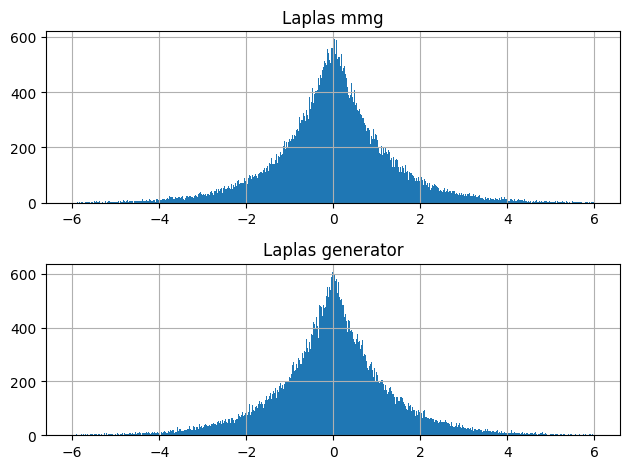

In [99]:
from scipy import stats
def laplas(a, n, l):
    data = []
    for i in range(n + 1):
        if a[i] == 0:
            data.append(0)
        else:
            data.append(l * np.log(a[i + 1] / a[i]))
    return data

l_laplas = 1
m = 0

laplas_mmg = laplas(mmg.U, n, l_laplas)
laplas_generator = laplas(generator, n, l_laplas)
bins = list(np.arange(-6, 6, 0.012))  
fig, axs = plt.subplots(2,1)
axs[0].hist(laplas_mmg, bins = bins)
axs[0].set_title("Laplas mmg")
axs[0].grid(True)
axs[1].hist(laplas_generator, bins = bins)
axs[1].set_title("Laplas generator")
axs[1].grid(True)
fig.tight_layout()
plt.show() 

Статистика для распределения Лапласа

In [100]:
def laplas_cdf(x, l):
    if x <= 0:
        return 0.5 * np.exp(x / l)
    else:
        return 1 - 0.5 * np.exp(-x / l)
    
print('Статистика для распределения Лапласа (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:", m)
print("Несмещенная оценка матожидания:", mmean(laplas_mmg))
print("Теоретическая дисперсия:",  2 / l_laplas ** 2)
print("Несмещенная оценка дисперсии:", vvar(laplas_mmg))

print('\nСтатистика для распределения Лапласа (встроенный генератор)')
print("Теоретическое мат. ожидание:", m)
print("Несмещенная оценка матожидания:", mmean(laplas_generator))
print("Теоретическая дисперсия:",  2 / l_laplas ** 2)
print("Несмещенная оценка дисперсии:", vvar(laplas_generator))


Статистика для распределения Лапласа (Маклорен-Марсалья)
Теоретическое мат. ожидание: 0
Несмещенная оценка матожидания: 8.090338023410609e-05
Теоретическая дисперсия: 2.0
Несмещенная оценка дисперсии: 2.0256372881745706

Статистика для распределения Лапласа (встроенный генератор)
Теоретическое мат. ожидание: 0
Несмещенная оценка матожидания: -1.2922193449740137e-06
Теоретическая дисперсия: 2.0
Несмещенная оценка дисперсии: 2.026205396022857


Критерий Колмогорова для распределения Лапласа

In [101]:
print('Критерий Колмогорова для MMG')
ks_test(laplas_mmg, laplas_cdf, l = l_laplas)
print('Критерий Колмогорова для встроенного генератора')
ks_test(laplas_generator, laplas_cdf, l=l_laplas)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.7282253286461448 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 0.8859313008209035 < 1.3580986393225505.


Хи-квадрат для распределения Лапласа

In [102]:
perform_chi2("Распределение Лапласа", laplas_mmg, laplas_generator, laplas_cdf, l = l_laplas)

Распределение Лапласа
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 950.0357547642716 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 1040.9754333391122 < 1073.6426506574246.


Распределение Вейбулла-Гнеденко

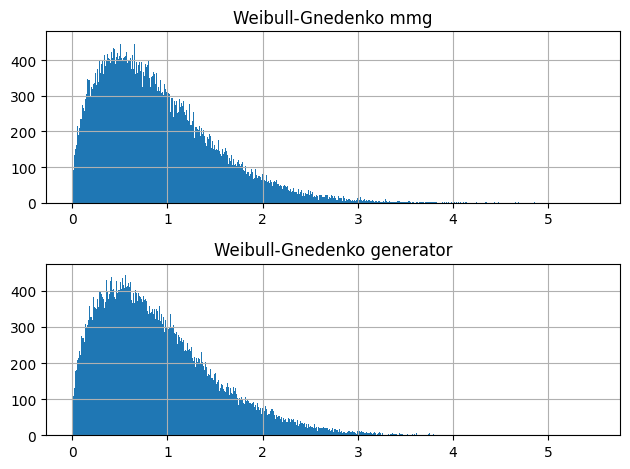

In [103]:
def WG(a, n, l, c):
    data = [((-1) * (1/l) * np.log(a[i]))**(1/c) if a[i] != 0 else 0 for i in range(n)]
    return data

l_wg = 1
c_wg = 1.5 
wg_mmg = WG(mmg.U, n, l_wg, c_wg)
wg_generator = WG(generator, n, l_wg, c_wg)
minn = min(wg_mmg + wg_generator)
maxx = max(wg_mmg + wg_generator)
bins = list(np.arange(minn, maxx, (maxx - minn) / 1000))  
fig, axs = plt.subplots(2,1)
axs[0].hist(wg_mmg, bins = bins)
axs[0].set_title("Weibull-Gnedenko mmg")
axs[0].grid(True)
axs[1].hist(wg_generator, bins = bins)
axs[1].set_title("Weibull-Gnedenko generator")
axs[1].grid(True)
fig.tight_layout()
plt.show() 

Статистика для распределения Вейбулла-Гнеденко

In [104]:
def wg_cdf(x, l, c):
    if x >= 0:
        return 1-math.e**((-1)*(x/l)**c)
    else:
        return 0
    
print('Статистика для распределения Вейбулла-Гнеденко (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:", l_wg**(-1/c_wg) * math.gamma(1 + 1/c_wg))
print("Несмещенная оценка матожидания:", mmean(wg_mmg))
print("Теоретическая дисперсия:",  l_wg**(-2/c_wg)*(math.gamma(1+2/c_wg)-(math.gamma(1+1/c_wg))**2))
print("Несмещенная оценка дисперсии:", vvar(wg_mmg))

print('\nСтатистика для распределения Вейбулла-Гнеденко (встроенный генератор)')
print("Теоретическое мат. ожидание:",l_wg**(-1/c_wg) * math.gamma(1 + 1/c_wg))
print("Несмещенная оценка матожидания:", mmean(wg_generator))
print("Теоретическая дисперсия:",   l_wg**(-2/c_wg)*(math.gamma(1+2/c_wg)-(math.gamma(1+1/c_wg))**2))
print("Несмещенная оценка дисперсии:", vvar(wg_generator))

Статистика для распределения Вейбулла-Гнеденко (Маклорен-Марсалья)
Теоретическое мат. ожидание: 0.9027452929509336
Несмещенная оценка матожидания: 0.9032226743064702
Теоретическая дисперсия: 0.37569028481393174
Несмещенная оценка дисперсии: 0.37660917376101216

Статистика для распределения Вейбулла-Гнеденко (встроенный генератор)
Теоретическое мат. ожидание: 0.9027452929509336
Несмещенная оценка матожидания: 0.9052791311844656
Теоретическая дисперсия: 0.37569028481393174
Несмещенная оценка дисперсии: 0.3783504942053877


Критерий Колмогорова для распределения Вейбулла

In [105]:
print('Критерий Колмогорова для MMG')
ks_test(wg_mmg, wg_cdf, l = l_wg, c = c_wg)
print('Критерий Колмогорова для встроенного генератора')
ks_test(wg_generator, wg_cdf, l = l_wg, c = c_wg)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.4316782921452041 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 0.8837229890860953 < 1.3580986393225505.


Хи-квадрат для распределения Вейбулла- Гнеденко

In [106]:
perform_chi2("Распределение Вейбулла-Гнеденко", wg_mmg, wg_generator, wg_cdf, l = l_wg, c = c_wg)

Распределение Вейбулла-Гнеденко
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 788.8807793958703 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 1015.9646154720826 < 1073.6426506574246.


Гамма - распределение 

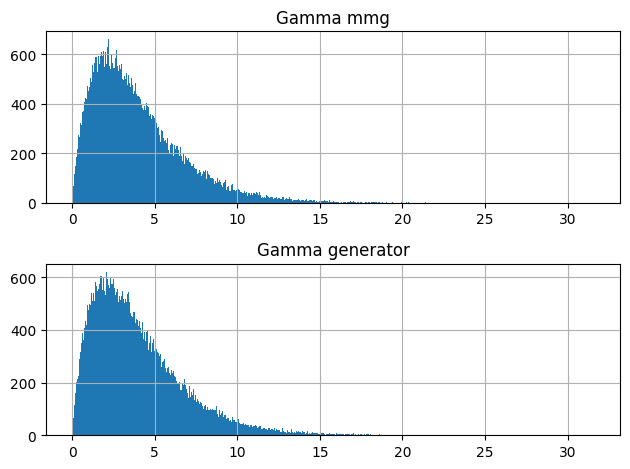

In [107]:
from scipy.stats import gamma
def comb(a):
    c = a[0]
    for i in range(1, len(a)):
        c = c * a[i]
    return c

def gamma_(a, n, b, nu):
    data = []
    for i in range(0, n * nu, nu):
        temp = np.log(comb(a[i:(i + nu)]))
        if temp == 0:
            data.append(0)
        else:
            data.append((-1) * temp * b)
    return data

b_gamma = 2
nu_gamma = 2 

gamma_mmg = gamma_(mmg.U, n, b_gamma, nu_gamma)
gamma_generator = gamma_(generator, n, b_gamma, nu_gamma)
minn = min(gamma_mmg + gamma_generator)
maxx = max(gamma_mmg + gamma_generator)
bins = list(np.arange(minn, maxx, (maxx - minn) / 1000))  
fig, axs = plt.subplots(2,1)
axs[0].hist(gamma_mmg, bins = bins)
axs[0].set_title("Gamma mmg")
axs[0].grid(True)
axs[1].hist(gamma_generator, bins = bins)
axs[1].set_title("Gamma generator")
axs[1].grid(True)
fig.tight_layout()
plt.show() 

Статистика для гамма-распределения

In [108]:

def gamma_cdf(x, b, nu):
    return  gamma.cdf(x, b, scale = nu)
print('Статистика для Гамма - распределения (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:",  nu_gamma * b_gamma)
print("Несмещенная оценка матожидания:", mmean(gamma_mmg))
print("Теоретическая дисперсия:",  nu_gamma * b_gamma ** 2)
print("Несмещенная оценка дисперсии:", vvar(gamma_mmg))

print('\nСтатистика для Гамма - распределения (встроенный генератор)')
print("Теоретическое мат. ожидание:", nu_gamma * b_gamma)
print("Несмещенная оценка матожидания:", mmean(gamma_generator))
print("Теоретическая дисперсия:", nu_gamma * b_gamma ** 2)
print("Несмещенная оценка дисперсии:", vvar(gamma_generator))


Статистика для Гамма - распределения (Маклорен-Марсалья)
Теоретическое мат. ожидание: 4
Несмещенная оценка матожидания: 4.009971658163587
Теоретическая дисперсия: 8
Несмещенная оценка дисперсии: 8.037581398843422

Статистика для Гамма - распределения (встроенный генератор)
Теоретическое мат. ожидание: 4
Несмещенная оценка матожидания: 4.011049144628293
Теоретическая дисперсия: 8
Несмещенная оценка дисперсии: 8.01033949994761


Критерий Колмогорова для Гамма-распределения

In [109]:
print('Критерий Колмогорова для MMG')
ks_test(gamma_mmg, gamma_cdf, b = b_gamma, nu = nu_gamma)
print('Критерий Колмогорова для встроенного генератора')
ks_test(gamma_generator, gamma_cdf, b = b_gamma, nu = nu_gamma)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.8542500784619108 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 1.0618886739183142 < 1.3580986393225505.


Хи- квадрат для Гамма - распределения

In [110]:
perform_chi2("Гамма - распределение", gamma_mmg, gamma_generator, gamma_cdf, b = b_gamma, nu = nu_gamma)

Гамма - распределение
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 942.8564274355409 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 800.1673595979861 < 1073.6426506574246.


Распределение Хи-квадрат

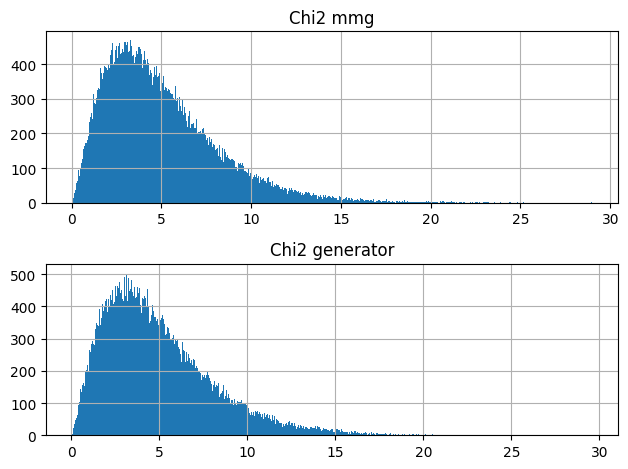

In [111]:
from scipy.stats import chi2

def chi2d(a, n, m):
    data = []
    res = []
    for i in range(0, n * m * 2 , 2):
        a1 = a[i]
        a2 = a[i + 1]
        data.append(np.sqrt(-2 * np.log(a1)) * np.cos(2 * np.pi * a2))
        data.append(np.sqrt(-2 * np.log(a1)) * np.sin(2 * np.pi * a2))  
    for i in range(0, n * m, m):
        res.append(sum([elem ** 2 for elem in data[i:(i + m)]]))
    return res

m_chi2 = 5
chi2_mmg = chi2d(mmg.U, n,m_chi2)
chi2_generator = chi2d(generator, n,m_chi2) 
fig, axs = plt.subplots(2,1)
axs[0].hist(chi2_mmg, bins = 1000)
axs[0].set_title("Chi2 mmg")
axs[0].grid(True)
axs[1].hist(chi2_generator, bins = 1000)
axs[1].set_title("Chi2 generator")
axs[1].grid(True)
fig.tight_layout()
plt.show() 

Статистика для распределения Хи-квадрат

In [112]:
import scipy.special
def chi2_cdf(x, m):
   return stats.chi2.cdf(x, m)
print('Статистика для распределения Хи-квадрат (Маклорен-Марсалья)')
print("Теоретическое мат. ожидание:", m_chi2)
print("Несмещенная оценка матожидания:", mmean(chi2_mmg))
print("Теоретическая дисперсия:",  2 * m_chi2)
print("Несмещенная оценка дисперсии:", vvar(chi2_mmg))

print('\nСтатистика для распределения Хи-квадрат (встроенный генератор)')
print("Теоретическое мат. ожидание:", m_chi2)
print("Несмещенная оценка матожидания:", mmean(chi2_generator))
print("Теоретическая дисперсия:", 2 * m_chi2)
print("Несмещенная оценка дисперсии:", vvar(chi2_generator))

Статистика для распределения Хи-квадрат (Маклорен-Марсалья)
Теоретическое мат. ожидание: 5
Несмещенная оценка матожидания: 5.014885859282345
Теоретическая дисперсия: 10
Несмещенная оценка дисперсии: 10.0085982392626

Статистика для распределения Хи-квадрат (встроенный генератор)
Теоретическое мат. ожидание: 5
Несмещенная оценка матожидания: 5.007624145025495
Теоретическая дисперсия: 10
Несмещенная оценка дисперсии: 10.103326593216975


Критерий Колмогорова для распределения Хи-квадрат

In [113]:
print('Критерий Колмогорова для MMG')
ks_test(chi2_mmg, chi2_cdf, m = m_chi2)
print('Критерий Колмогорова для встроенного генератора')
ks_test(chi2_generator, chi2_cdf, m = m_chi2)

Критерий Колмогорова для MMG

	Уровень доверия: 0.95
	H0 принята: 0.8354494494817991 < 1.3580986393225505.
Критерий Колмогорова для встроенного генератора

	Уровень доверия: 0.95
	H0 принята: 0.7262210713534378 < 1.3580986393225505.


Хи-квадрат для распределения Хи-квадрат

In [114]:
perform_chi2("Хи-квадрат", chi2_mmg, chi2_generator, chi2_cdf, m = m_chi2)

Хи-квадрат
Хи-квадрат для встроенного генератора
	Уровень доверия: 0.95
	H0 принята: 1001.0226822102675 < 1073.6426506574246.
Хи-квадрат для реализованного генератора
	Уровень доверия: 0.95
	H0 принята: 868.785634303596 < 1073.6426506574246.
